# 2A.ml - Réduction d'une forêt aléatoire - correction

Le modèle Lasso permet de sélectionner des variables, une forêt aléatoire produit une prédiction comme étant la moyenne d'arbres de régression. Et si on mélangeait les deux ?

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

## Datasets

Comme il faut toujours des données, on prend ce jeu [Boston](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html).

In [3]:
from sklearn.datasets import load_diabetes
data = load_diabetes()
X, y = data.data, data.target

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

## Une forêt aléatoire

In [5]:
from sklearn.ensemble import RandomForestRegressor as model_class
clr = model_class()
clr.fit(X_train, y_train)

RandomForestRegressor()

Le nombre d'arbres est...

In [6]:
len(clr.estimators_)

100

In [7]:
from sklearn.metrics import r2_score
r2_score(y_test, clr.predict(X_test))

0.45644838513417174

## Random Forest = moyenne des prédictions

On recommence en faisant la moyenne soi-même.

In [8]:
import numpy
dest = numpy.zeros((X_test.shape[0], len(clr.estimators_)))
estimators = numpy.array(clr.estimators_).ravel()
for i, est in enumerate(estimators):
    pred = est.predict(X_test)
    dest[:, i] = pred

average = numpy.mean(dest, axis=1)
r2_score(y_test, average)

0.45644838513417174

A priori, c'est la même chose.

## Pondérer les arbres à l'aide d'une régression linéaire

La forêt aléatoire est une façon de créer de nouvelles features, 100 exactement qu'on utilise pour caler une régression linéaire.

In [9]:
from sklearn.linear_model import LinearRegression


def new_features(forest, X):
    dest = numpy.zeros((X.shape[0], len(forest.estimators_)))
    estimators = numpy.array(forest.estimators_).ravel()
    for i, est in enumerate(estimators):
        pred = est.predict(X)
        dest[:, i] = pred
    return dest


X_train_2 = new_features(clr, X_train)
lr = LinearRegression()
lr.fit(X_train_2, y_train)

LinearRegression()

In [10]:
X_test_2 = new_features(clr, X_test)
r2_score(y_test, lr.predict(X_test_2))

0.4134869746554457

Un peu moins bien, un peu mieux, le risque d'overfitting est un peu plus grand avec ces nombreuses features car la base d'apprentissage ne contient que 379 observations (regardez ``X_train.shape`` pour vérifier).

In [11]:
lr.coef_

array([-2.09457865e-02,  1.29679061e-02,  9.43392755e-03, -7.51148999e-03,
        5.16087918e-02,  1.83294655e-02,  7.23653628e-03,  1.80807456e-02,
       -3.25298371e-03,  1.04952870e-01,  1.66235396e-02,  3.58901717e-02,
       -1.57599927e-02,  3.93075217e-02, -1.03558301e-02,  3.68480355e-02,
        6.60151676e-02,  7.21841424e-03, -3.22447652e-02, -7.11075349e-03,
        2.56119700e-02,  8.70448289e-03,  1.52166943e-02, -4.77073501e-02,
       -2.79973243e-02,  3.98248622e-03,  3.41335072e-02,  4.37761968e-02,
       -2.86609769e-02,  5.84325383e-04, -2.41816894e-02, -4.31525604e-02,
       -2.94690996e-02,  4.12262686e-02,  3.15810096e-04, -3.16758484e-02,
        3.26218949e-02,  3.94270066e-02, -1.43895048e-02, -1.23290740e-02,
        7.54401474e-02,  4.37096599e-02,  2.41821413e-03,  3.20217041e-02,
       -3.11952579e-02,  3.14644464e-03,  4.65619038e-02,  1.72257142e-03,
        1.33921245e-02,  4.24316712e-02,  3.07044263e-03,  4.32540380e-02,
        3.65472907e-02, -

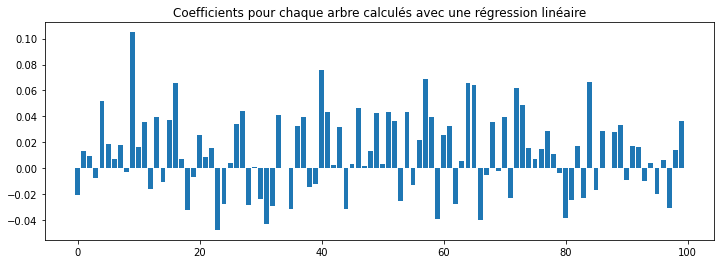

In [12]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.bar(numpy.arange(0, len(lr.coef_)), lr.coef_)
ax.set_title("Coefficients pour chaque arbre calculés avec une régression linéaire");

Le score est avec une régression linéaire sur les variables initiales est nettement moins élevé.

In [13]:
lr_raw = LinearRegression()
lr_raw.fit(X_train, y_train)
r2_score(y_test, lr_raw.predict(X_test))

0.49450365296272114

## Sélection d'arbres

L'idée est d'utiliser un algorithme de sélection de variables type [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) pour réduire la forêt aléatoire sans perdre en performance. C'est presque le même code.

In [14]:
from sklearn.linear_model import Lasso

lrs = Lasso(max_iter=10000)
lrs.fit(X_train_2, y_train)
lrs.coef_

array([-0.01957286,  0.01233369,  0.00954118, -0.00569504,  0.05049884,
        0.01689251,  0.00654297,  0.01733487, -0.001983  ,  0.10400337,
        0.01641583,  0.03557317, -0.01438057,  0.03812027, -0.00941841,
        0.03543891,  0.06498173,  0.00790916, -0.03173719, -0.00512061,
        0.02618226,  0.00872055,  0.0131708 , -0.04746082, -0.02753308,
        0.00404911,  0.03485009,  0.04268146, -0.02774186,  0.        ,
       -0.02320031, -0.04180379, -0.02657871,  0.04069398,  0.0001481 ,
       -0.02846403,  0.03199247,  0.03842821, -0.01314624, -0.01076699,
        0.07402192,  0.04288976,  0.00227952,  0.03126979, -0.02792699,
        0.00095921,  0.0462247 ,  0.00120941,  0.01234276,  0.04226981,
        0.00160673,  0.0427622 ,  0.03551004, -0.02358261,  0.04337921,
       -0.01070174,  0.02080949,  0.06721657,  0.03804108, -0.03936158,
        0.02494815,  0.03105243, -0.02499851,  0.00457056,  0.06495372,
        0.06310639, -0.03850654, -0.00462205,  0.03420462, -0.00

Pas mal de zéros donc pas mal d'arbres non utilisés.

In [15]:
r2_score(y_test, lrs.predict(X_test_2))

0.41523953764907784

Pas trop de perte... Ca donne envie d'essayer plusieurs valeur de `alpha`.

In [16]:
from tqdm import tqdm
alphas = [0.01 * i for i in range(100)] +[1 + 0.1 * i for i in range(100)]
obs = []
for i in tqdm(range(0, len(alphas))):
    alpha = alphas[i]
    lrs = Lasso(max_iter=20000, alpha=alpha)
    lrs.fit(X_train_2, y_train)
    obs.append(dict(
        alpha=alpha,
        null=len(lrs.coef_[lrs.coef_!=0]),
        r2=r2_score(y_test, lrs.predict(X_test_2))
    ))

  0%|          | 0/200 [00:00<?, ?it/s]<ipython-input-50-9ddf7d241c96>:7: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lrs.fit(X_train_2, y_train)
C:\Python395_x64\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Python395_x64\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.376e+04, tolerance: 1.963e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
100%|█████████

In [17]:
from pandas import DataFrame
df = DataFrame(obs)
df.tail()

,alpha,null,r2
195,10.5,83,0.429636
196,10.6,83,0.429767
197,10.7,83,0.429898
198,10.8,83,0.430029
199,10.9,83,0.430158


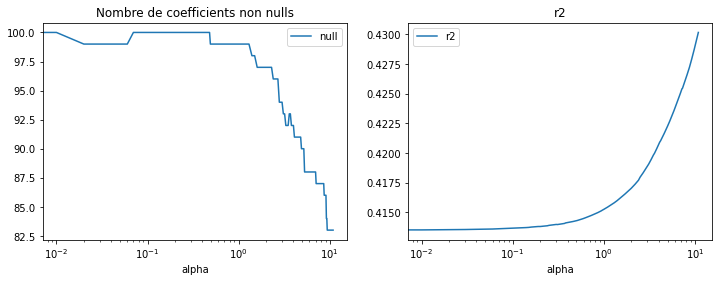

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
df[["alpha", "null"]].set_index("alpha").plot(ax=ax[0], logx=True)
ax[0].set_title("Nombre de coefficients non nulls")
df[["alpha", "r2"]].set_index("alpha").plot(ax=ax[1], logx=True)
ax[1].set_title("r2");

Dans ce cas, supprimer des arbres augmente la performance, comme évoqué ci-dessus, cela réduit l'overfitting. Le nombre d'arbres peut être réduit des deux tiers avec ce modèle.